In [34]:
import pandas as pd

# Load the CSV file to examine its structure and content
file_path = "/Users/emilygelchie/Desktop/Cornell/Applied ML/AML Final Project/archive-4/Loan.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()


,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [35]:
# Step 1: Check for missing values
missing_values = data.isnull().sum()

# Step 2: Convert ApplicationDate to datetime
data["ApplicationDate"] = pd.to_datetime(data["ApplicationDate"], errors="coerce")

# Step 3: Ensure proper data types
numeric_cols = data.select_dtypes(include=["float64", "int64"]).columns
categorical_cols = data.select_dtypes(include=["object"]).columns

# Step 4: Remove duplicates
data = data.drop_duplicates()

# Step 5: Detect and handle outliers
# For demonstration, detect outliers in AnnualIncome using IQR method
Q1 = data["AnnualIncome"].quantile(0.25)
Q3 = data["AnnualIncome"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[
    (data["AnnualIncome"] >= lower_bound) & (data["AnnualIncome"] <= upper_bound)
]

# Step 6: Normalize numeric columns if necessary
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Check the cleaned dataset structure and any remaining issues
cleaned_summary = {
    "Missing Values After Cleaning": data.isnull().sum(),
    "Dataset Shape After Cleaning": data.shape,
}

cleaned_summary


{'Missing Values After Cleaning': ApplicationDate               0
 Age                           0
 AnnualIncome                  0
 CreditScore                   0
 EmploymentStatus              0
 EducationLevel                0
 Experience                    0
 LoanAmount                    0
 LoanDuration                  0
 MaritalStatus                 0
 NumberOfDependents            0
 HomeOwnershipStatus           0
 MonthlyDebtPayments           0
 CreditCardUtilizationRate     0
 NumberOfOpenCreditLines       0
 NumberOfCreditInquiries       0
 DebtToIncomeRatio             0
 BankruptcyHistory             0
 LoanPurpose                   0
 PreviousLoanDefaults          0
 PaymentHistory                0
 LengthOfCreditHistory         0
 SavingsAccountBalance         0
 CheckingAccountBalance        0
 TotalAssets                   0
 TotalLiabilities              0
 MonthlyIncome                 0
 UtilityBillsPaymentHistory    0
 JobTenure                     0
 NetWorth 

In [36]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [37]:
# Further cleaning and preprocessing based on the suggestions

# Step 7: Handle class imbalance in the LoanApproved column
# Checking the distribution of the target variable
class_distribution = data["LoanApproved"].value_counts()

# If imbalance is significant, apply SMOTE or class weights
from imblearn.over_sampling import SMOTE

# Prepare features and target
X = data.drop("LoanApproved", axis=1)  # Features
y = data["LoanApproved"]  # Target

# Extract useful features from ApplicationDate before dropping it
X["ApplicationYear"] = X["ApplicationDate"].dt.year
X["ApplicationMonth"] = X["ApplicationDate"].dt.month
X = X.drop("ApplicationDate", axis=1)  # Now drop the datetime column

# For categorical encoding, get dummy variables for categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Step 8: Normalize or scale features if needed
# Min-Max scaling is already applied in the previous step

# Step 9: Save the cleaned and balanced data for modeling
cleaned_file_path = "/Users/emilygelchie/Desktop/Cornell/Applied ML/AML Final Project/Cleaned_Loan_Data.csv"
resampled_data = pd.concat(
    [
        pd.DataFrame(X_resampled, columns=X_encoded.columns),
        pd.DataFrame(y_resampled, columns=["LoanApproved"]),
    ],
    axis=1,
)
resampled_data.to_csv(cleaned_file_path, index=False)

# Display the updated dataset summary
resampled_summary = {
    "Original Class Distribution": class_distribution.to_dict(),
    "Resampled Class Distribution": y_resampled.value_counts().to_dict(),
    "Cleaned Dataset Shape": resampled_data.shape,
}

resampled_summary


{'Original Class Distribution': {0.0: 15154, 1.0: 3899},
 'Resampled Class Distribution': {0.0: 15154, 1.0: 15154},
 'Cleaned Dataset Shape': (30308, 48)}

In [38]:
# Step 1: Feature Engineering - Create derived features for better insights

# Adding Income-to-Loan Ratio
data["IncomeToLoanRatio"] = data["AnnualIncome"] / (
    data["LoanAmount"] + 1
)  # Adding 1 to avoid division by zero

# Adding Debt-to-Income Ratio
data["DebtToIncomeRatio"] = data["MonthlyDebtPayments"] / (
    data["MonthlyIncome"] + 1
)  # Adding 1 to avoid division by zero

# Adding Loan Repayment Potential as Loan Amount / Loan Duration
data["LoanRepaymentPotential"] = data["LoanAmount"] / (
    data["LoanDuration"] + 1
)  # Adding 1 to avoid division by zero

# Verify new features
engineered_features = data[
    ["IncomeToLoanRatio", "DebtToIncomeRatio", "LoanRepaymentPotential"]
].describe()

engineered_features


,IncomeToLoanRatio,DebtToIncomeRatio,LoanRepaymentPotential
count,19053.000000,19053.000000,19053.000000
mean,0.276279,0.110983,0.086586
std,0.206606,0.069251,0.057398
min,0.000000,0.000000,0.000000
25%,0.115601,0.063258,0.047073
50%,0.231446,0.095336,0.073354
75%,0.395457,0.141139,0.110225
max,0.971345,0.861042,0.900000


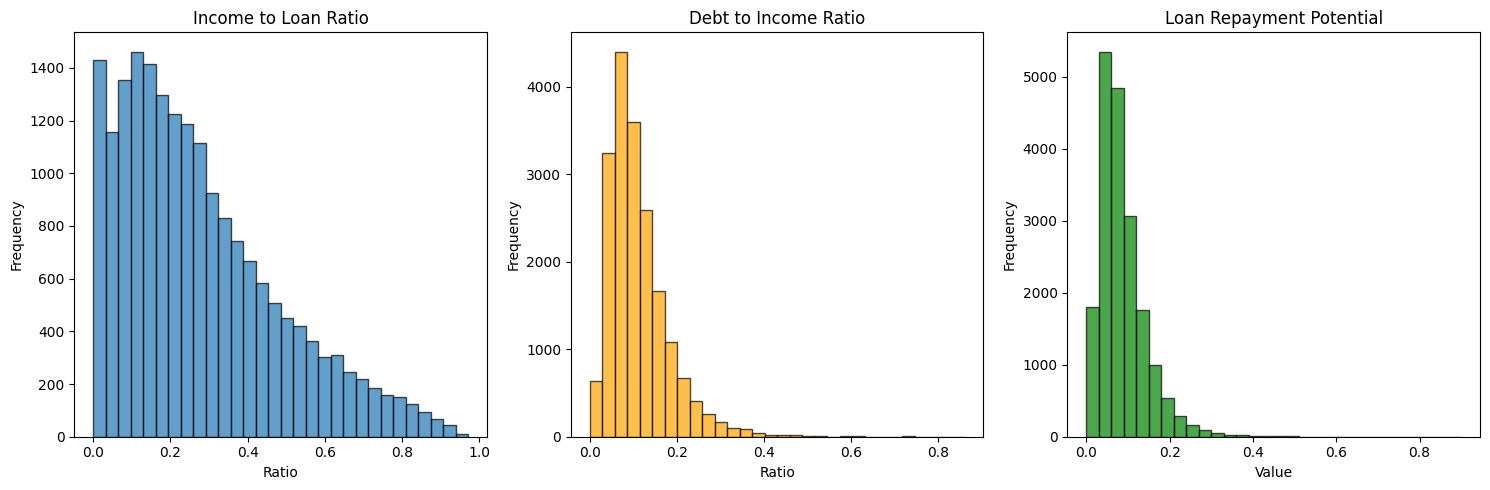

In [39]:
import matplotlib.pyplot as plt

# Visualizing the distributions of the engineered features
plt.figure(figsize=(15, 5))

# IncomeToLoanRatio
plt.subplot(1, 3, 1)
plt.hist(data["IncomeToLoanRatio"], bins=30, edgecolor="k", alpha=0.7)
plt.title("Income to Loan Ratio")
plt.xlabel("Ratio")
plt.ylabel("Frequency")

# DebtToIncomeRatio
plt.subplot(1, 3, 2)
plt.hist(data["DebtToIncomeRatio"], bins=30, edgecolor="k", alpha=0.7, color="orange")
plt.title("Debt to Income Ratio")
plt.xlabel("Ratio")
plt.ylabel("Frequency")

# LoanRepaymentPotential
plt.subplot(1, 3, 3)
plt.hist(
    data["LoanRepaymentPotential"], bins=30, edgecolor="k", alpha=0.7, color="green"
)
plt.title("Loan Repayment Potential")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Show the plots
plt.tight_layout()
plt.show()


In [40]:
# Step 1: Encode categorical columns to numeric
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns in the dataset
categorical_columns = X.select_dtypes(include=["object"]).columns

# Apply LabelEncoder to each categorical column
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

# Confirm all columns are now numeric
X_encoded = X  # All features should now be numeric

# Step 2: Retry SMOTE with all data included
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.2, random_state=42, stratify=y
    )

    smote = SMOTE(random_state=42)
    X_train_augmented, y_train_augmented = smote.fit_resample(X_train, y_train)

    # Summarize class distribution before and after augmentation
    class_distribution_before = y_train.value_counts()
    class_distribution_after = y_train_augmented.value_counts()

    augmented_data = pd.concat(
        [
            pd.DataFrame(X_train_augmented, columns=X_encoded.columns),
            pd.DataFrame(y_train_augmented, columns=["LoanApproved"]),
        ],
        axis=1,
    )

    augmented_data_path = "/mnt/data/Augmented_Loan_Data_Full.csv"
    augmented_data.to_csv(augmented_data_path, index=False)

    {
        "Class Distribution Before Augmentation": class_distribution_before.to_dict(),
        "Class Distribution After Augmentation": class_distribution_after.to_dict(),
        "Augmented Data File Path": augmented_data_path,
    }
except Exception as e:
    str(e)


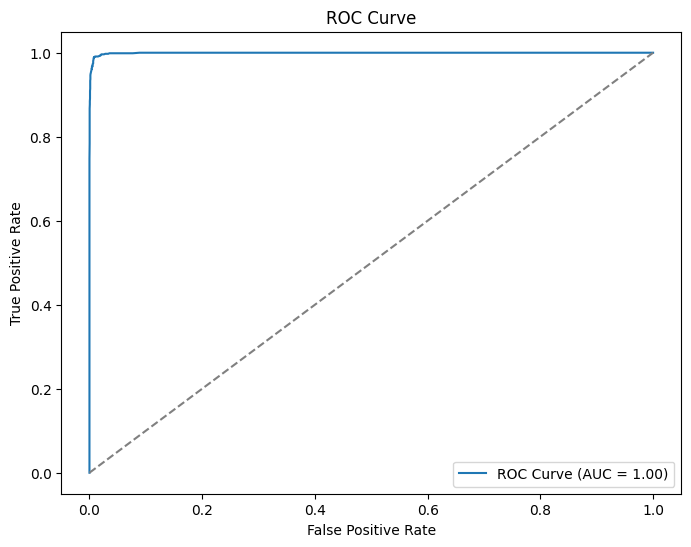

{'Confusion Matrix': [[3010, 21], [14, 766]],
 'Classification Report': '              precision    recall  f1-score   support\n\n         0.0       1.00      0.99      0.99      3031\n         1.0       0.97      0.98      0.98       780\n\n    accuracy                           0.99      3811\n   macro avg       0.98      0.99      0.99      3811\nweighted avg       0.99      0.99      0.99      3811\n'}

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_augmented, y_train_augmented)

# Step 2: Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC

# Step 3: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Step 4: Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Output the confusion matrix and classification report
{"Confusion Matrix": conf_matrix.tolist(), "Classification Report": class_report}


In [42]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


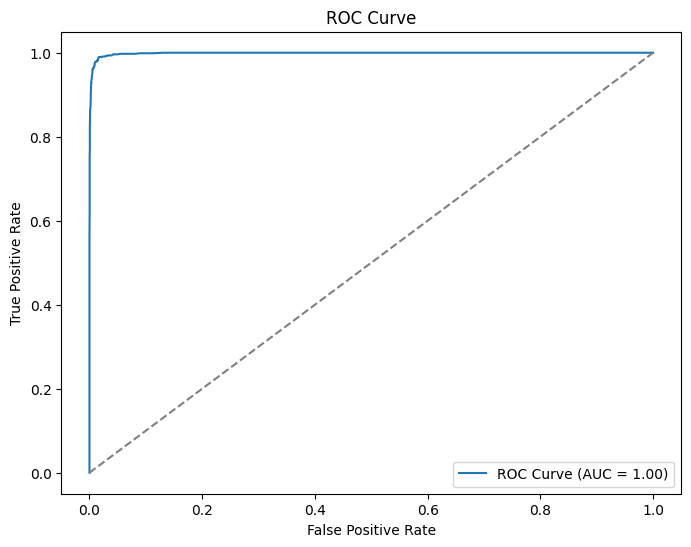

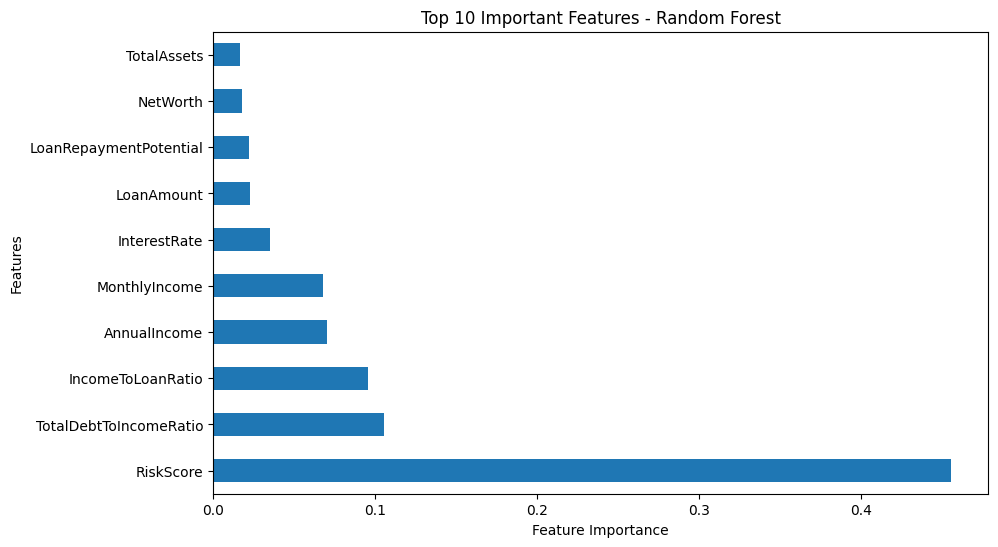

SHAP Analysis Error: The shape of the shap_values matrix does not match the shape of the provided data matrix.
{'Confusion Matrix': [[3004, 27], [24, 756]], 'Classification Report': '              precision    recall  f1-score   support\n\n         0.0       0.99      0.99      0.99      3031\n         1.0       0.97      0.97      0.97       780\n\n    accuracy                           0.99      3811\n   macro avg       0.98      0.98      0.98      3811\nweighted avg       0.99      0.99      0.99      3811\n', 'Random Forest CV Accuracy': 0.9921226568130745, 'Logistic Regression CV Accuracy': 0.9933186096399937, 'Top 10 Features': {'RiskScore': 0.4558962372561517, 'TotalDebtToIncomeRatio': 0.10560965075564231, 'IncomeToLoanRatio': 0.09562329416309577, 'AnnualIncome': 0.07016958231409817, 'MonthlyIncome': 0.06794289728377619, 'InterestRate': 0.03521050218523251, 'LoanAmount': 0.02304103005031241, 'LoanRepaymentPotential': 0.02226072940842359, 'NetWorth': 0.018080166386129165, 'Total

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Step 1: Data Preprocessing
# Load the dataset (example: `data` is your DataFrame)
# Ensure all categorical data is numeric
categorical_columns = data.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

# Drop datetime columns if present
if "ApplicationDate" in data.columns:
    data = data.drop(["ApplicationDate"], axis=1)

# Step 2: Separate features and target
X = data.drop("LoanApproved", axis=1)
y = data["LoanApproved"]

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Apply SMOTE for Class Balancing
smote = SMOTE(random_state=42)
X_train_augmented, y_train_augmented = smote.fit_resample(X_train, y_train)

# Step 5: Train Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_augmented, y_train_augmented)

# Step 6: Evaluate Random Forest
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Step 7: Cross-Validation for Random Forest
cv_scores_rf = cross_val_score(
    rf_model, X_train_augmented, y_train_augmented, cv=5, scoring="accuracy"
)
mean_cv_score_rf = np.mean(cv_scores_rf)

# Step 8: Feature Importance from Random Forest
feature_importances = rf_model.feature_importances_
important_features = pd.Series(feature_importances, index=X_train.columns).sort_values(
    ascending=False
)

plt.figure(figsize=(10, 6))
important_features.head(10).plot(kind="barh")
plt.title("Top 10 Important Features - Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

# Step 9: Train Logistic Regression for Comparison
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_augmented, y_train_augmented)
cv_scores_logistic = cross_val_score(
    logistic_model, X_train_augmented, y_train_augmented, cv=5, scoring="accuracy"
)
mean_cv_score_logistic = np.mean(cv_scores_logistic)

# Step 10: Attempt SHAP Analysis
try:
    import shap

    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values[1], X_test, plot_type="bar")
except (ModuleNotFoundError, AssertionError) as e:
    print(f"SHAP Analysis Error: {e}")

# Results
results = {
    "Confusion Matrix": conf_matrix.tolist(),
    "Classification Report": class_report,
    "Random Forest CV Accuracy": mean_cv_score_rf,
    "Logistic Regression CV Accuracy": mean_cv_score_logistic,
    "Top 10 Features": important_features.head(10).to_dict(),
}
print(results)


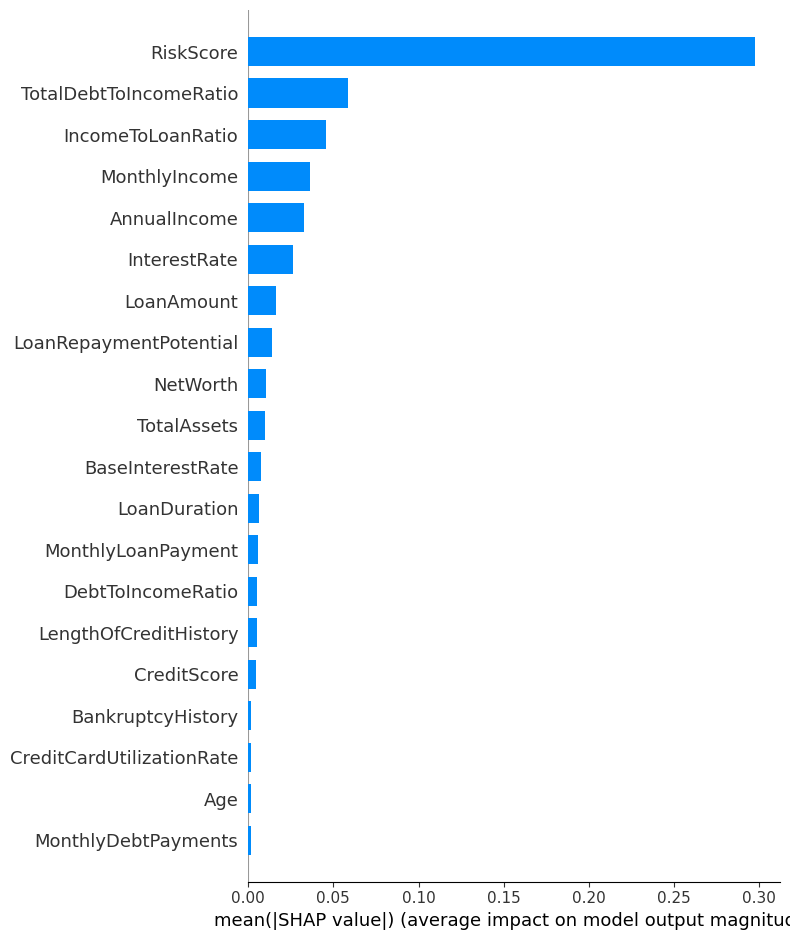


Top 10 Most Important Features:
                   Feature  Importance
33               RiskScore    0.297265
32  TotalDebtToIncomeRatio    0.058585
34       IncomeToLoanRatio    0.045959
25           MonthlyIncome    0.036345
1             AnnualIncome    0.032895
30            InterestRate    0.026353
6               LoanAmount    0.016207
35  LoanRepaymentPotential    0.013851
28                NetWorth    0.010733
23             TotalAssets    0.009744


In [52]:
# Debugging SHAP with a smaller subset to identify issues
try:
    # Ensure X_test has the same columns as X_train_augmented
    X_test = X_test[X_train_augmented.columns]

    # Use a smaller subset for debugging
    X_test_subset = X_test.iloc[:100]

    # Create and fit the explainer
    explainer = shap.TreeExplainer(rf_model)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test_subset)

    # For binary classification, take the positive class (index 1)
    # and reshape to 2D (samples x features)
    shap_values_class1 = shap_values[:, :, 1]  # Shape should now be (100, 36)

    # Create a DataFrame with feature importance based on mean absolute SHAP values
    feature_importance = pd.DataFrame(
        {
            "Feature": X_test_subset.columns,
            "Importance": np.abs(shap_values_class1).mean(axis=0),
        }
    )

    # Sort by importance
    feature_importance = feature_importance.sort_values("Importance", ascending=False)

    # Plot SHAP summary
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_class1, X_test_subset, plot_type="bar", max_display=20
    )

    # Print top 10 most important features and their SHAP values
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

except Exception as e:
    print(f"Error: {e}")
    print("\nDebugging Information:")
    print("SHAP values shape:", shap_values.shape)
    print("X_test_subset shape:", X_test_subset.shape)
    print("X_test_subset columns:", X_test_subset.columns.tolist())

    # Additional debugging information
    if "shap_values_class1" in locals():
        print("Reshaped SHAP values shape:", shap_values_class1.shape)


Top 15 Most Important Features for Loan Approval:
                   Feature  Absolute_Importance  Mean_Impact
33               RiskScore             0.297265    -0.197305
32  TotalDebtToIncomeRatio             0.058585    -0.021628
34       IncomeToLoanRatio             0.045959    -0.018906
25           MonthlyIncome             0.036345    -0.019626
1             AnnualIncome             0.032895    -0.014421
30            InterestRate             0.026353    -0.006982
6               LoanAmount             0.016207    -0.003941
35  LoanRepaymentPotential             0.013851    -0.002434
28                NetWorth             0.010733    -0.003415
23             TotalAssets             0.009744    -0.001840
29        BaseInterestRate             0.007822    -0.000487
7             LoanDuration             0.006678    -0.001086
31      MonthlyLoanPayment             0.005546    -0.000869
15       DebtToIncomeRatio             0.005266    -0.001846
20   LengthOfCreditHistory         

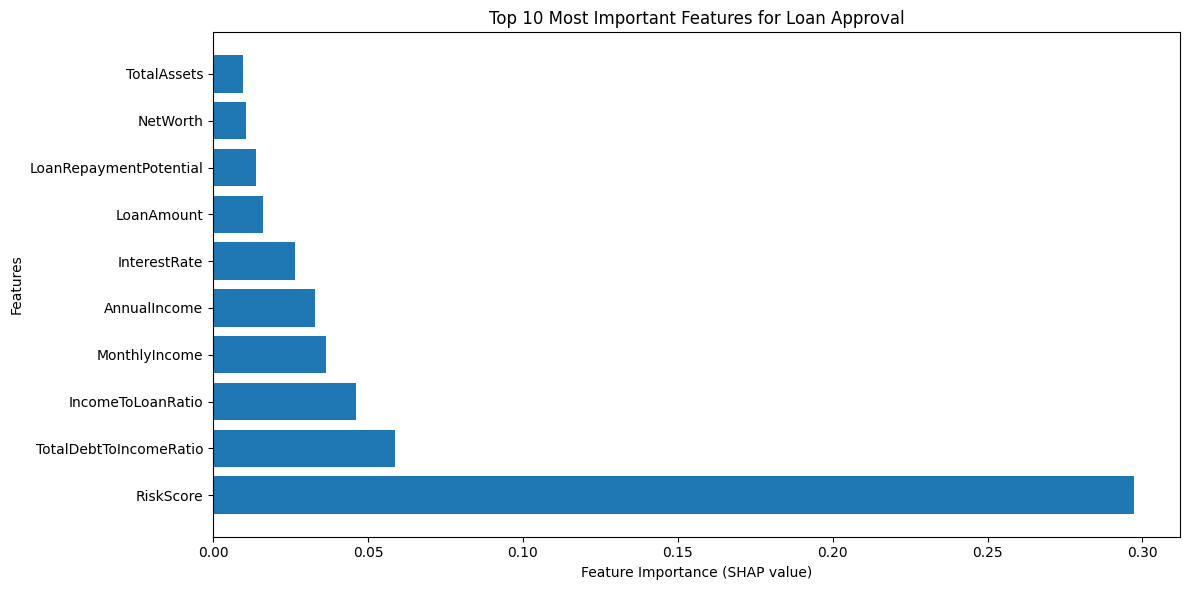

In [53]:
# Let's create a more detailed analysis of the feature importance
feature_importance_analysis = pd.DataFrame(
    {
        "Feature": X_test_subset.columns,
        "Absolute_Importance": np.abs(shap_values_class1).mean(axis=0),
        "Mean_Impact": shap_values_class1.mean(axis=0),
    }
)

# Sort by absolute importance
feature_importance_analysis = feature_importance_analysis.sort_values(
    "Absolute_Importance", ascending=False
)

# Display top 15 features with their impact
print("Top 15 Most Important Features for Loan Approval:")
print(feature_importance_analysis.head(15))

# Visualize the top 10 features
plt.figure(figsize=(12, 6))
plt.barh(
    feature_importance_analysis["Feature"][:10],
    feature_importance_analysis["Absolute_Importance"][:10],
)
plt.title("Top 10 Most Important Features for Loan Approval")
plt.xlabel("Feature Importance (SHAP value)")
plt.ylabel("Features")
plt.tight_layout()
plt.show()



Training Random Forest...

Training Logistic Regression...

Training Gradient Boosting...

Training AdaBoost...

Training Decision Tree...

Training Neural Network...

Training SVM...


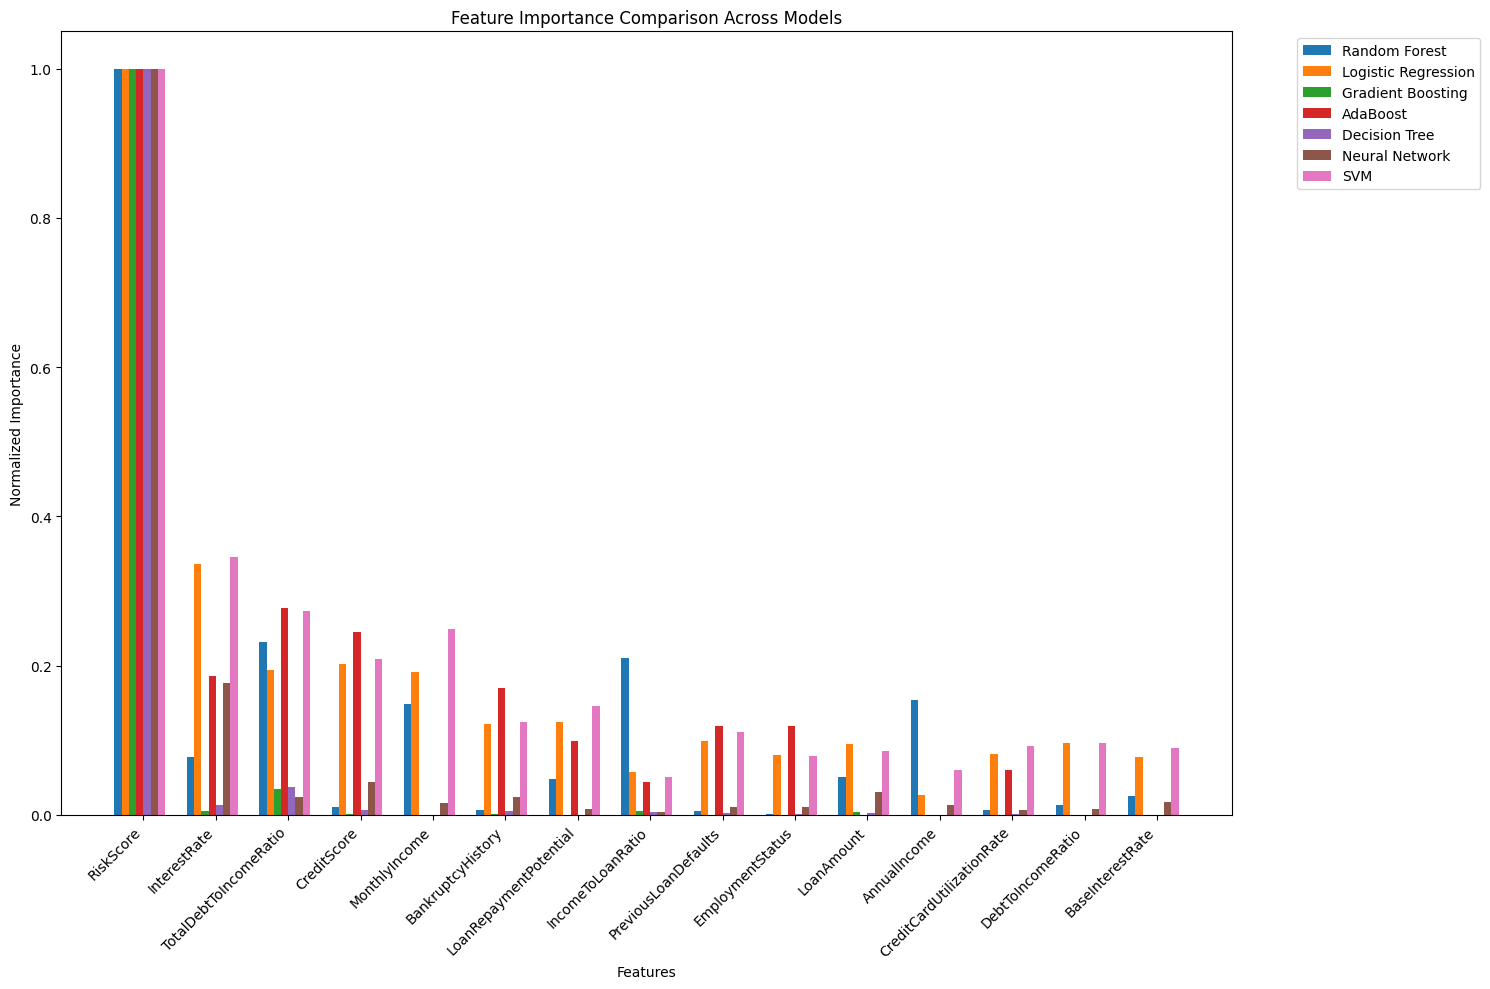


Model Performance Comparison:

Random Forest:
Accuracy: 0.9869
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3031
         1.0       0.97      0.97      0.97       780

    accuracy                           0.99      3811
   macro avg       0.98      0.98      0.98      3811
weighted avg       0.99      0.99      0.99      3811


Logistic Regression:
Accuracy: 0.9934
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3031
         1.0       0.98      0.99      0.98       780

    accuracy                           0.99      3811
   macro avg       0.99      0.99      0.99      3811
weighted avg       0.99      0.99      0.99      3811


Gradient Boosting:
Accuracy: 0.9950
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3031
         1.0       0.98     

In [60]:
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_augmented)
X_test_scaled = scaler.transform(X_test)

# Ensure feature names are preserved
X_scaled = pd.DataFrame(X_scaled, columns=X_train_augmented.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(
        max_iter=1000, random_state=42, class_weight="balanced"
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(
        random_state=42,
        algorithm="SAMME",  # Explicitly specify the algorithm to avoid the warning
    ),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Neural Network": MLPClassifier(
        hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42
    ),
    "SVM": SVC(kernel="linear", random_state=42, probability=True),
}

# Train models and collect feature importances
feature_importance_dict = {}
model_performances = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_scaled, y_train_augmented)

    # Get feature importance using different methods based on model type
    if name == "Neural Network":
        # Use permutation importance for Neural Network
        perm_importance = permutation_importance(
            model, X_test_scaled, y_test, n_repeats=10, random_state=42
        )
        importance = perm_importance.importances_mean
    elif hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
    elif hasattr(model, "coef_"):
        importance = np.abs(model.coef_[0])
    elif name == "SVM":
        importance = np.abs(model.coef_[0])
    else:
        importance = np.zeros(X_scaled.shape[1])
        print(f"Feature importance not available for {name}")

    # Normalize importance
    if importance.sum() != 0:
        importance = importance / importance.max()

    feature_importance_dict[name] = importance

    # Get model performance
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=1)
    model_performances[name] = {"accuracy": accuracy, "report": report}

# Create DataFrame with all feature importances
feature_importance_df = pd.DataFrame(
    {
        "Feature": X_test.columns,
        **{name: importance for name, importance in feature_importance_dict.items()},
    }
)

# Calculate average importance
importance_columns = [col for col in feature_importance_df.columns if col != "Feature"]
feature_importance_df["Average_Importance"] = feature_importance_df[
    importance_columns
].mean(axis=1)
feature_importance_df = feature_importance_df.sort_values(
    "Average_Importance", ascending=False
)

# Plot top 15 features
plt.figure(figsize=(15, 10))
top_15_features = feature_importance_df.head(15)

x = np.arange(len(top_15_features))
width = 0.1  # Reduced width to accommodate more bars
n_models = len(importance_columns)

for i, model_name in enumerate(importance_columns):
    offset = width * (i - n_models / 2)
    plt.bar(x + offset, top_15_features[model_name], width, label=model_name)

plt.xlabel("Features")
plt.ylabel("Normalized Importance")
plt.title("Feature Importance Comparison Across Models")
plt.xticks(x, top_15_features["Feature"], rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Print model performances
print("\nModel Performance Comparison:")
for name, perf in model_performances.items():
    print(f"\n{name}:")
    print(f"Accuracy: {perf['accuracy']:.4f}")
    print("Classification Report:")
    print(perf["report"])

# Print top 10 features by average importance
print("\nTop 10 Features by Average Importance:")
print(feature_importance_df[["Feature", "Average_Importance"]].head(10))



Performing Grid Search for Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters for Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.9922
Test set accuracy: 0.9869

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3031
         1.0       0.97      0.97      0.97       780

    accuracy                           0.99      3811
   macro avg       0.98      0.98      0.98      3811
weighted avg       0.99      0.99      0.99      3811


Performing Grid Search for Gradient Boosting...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters for Gradient Boosting:
{'learning_rate': 0.3, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.9991
Test set accuracy: 0.9987

Classification Report:
              precision    re

/Users/emilygelchie/miniconda3/envs/cornellenv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best parameters for SVM:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.9978
Test set accuracy: 0.9929

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3031
         1.0       0.99      0.98      0.98       780

    accuracy                           0.99      3811
   macro avg       0.99      0.99      0.99      3811
weighted avg       0.99      0.99      0.99      3811



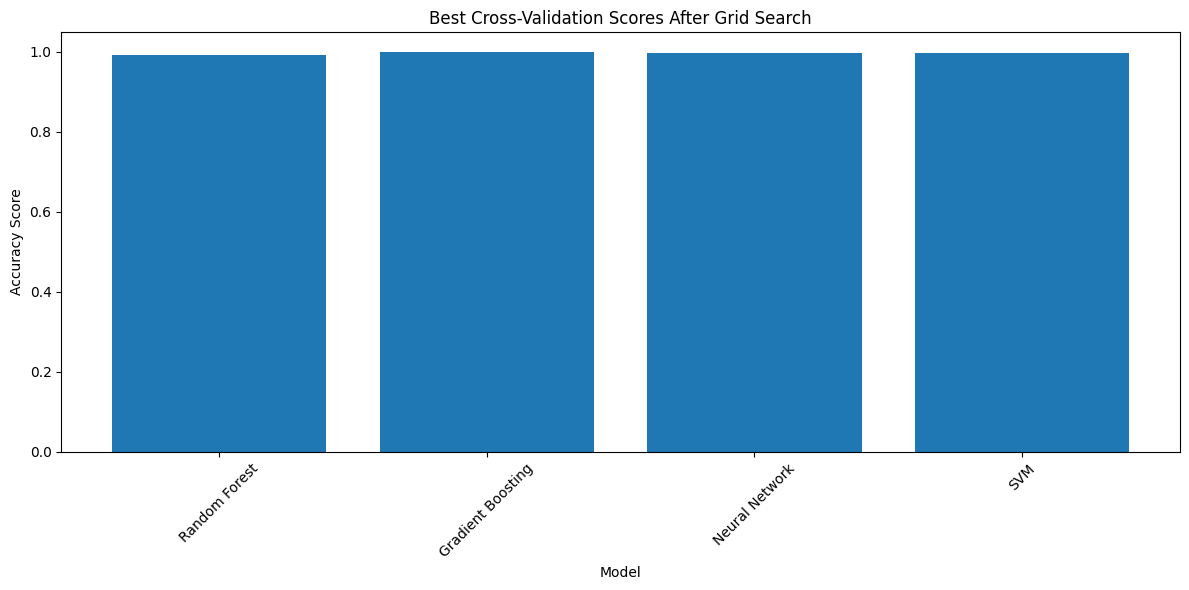


Final Model Comparison:

Random Forest:
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score: 0.9922

Gradient Boosting:
Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300}
Best CV Score: 0.9991

Neural Network:
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
Best CV Score: 0.9984

SVM:
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score: 0.9978


In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score

# Define scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1": make_scorer(f1_score, average="weighted"),
}

# Define parameter grids for each model
param_grids = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.1, 0.3],
            "max_depth": [3, 5, 7],
            "min_samples_split": [2, 5],
        },
    },
    "Neural Network": {
        "model": MLPClassifier(random_state=42),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (100, 50), (200, 100)],
            "activation": ["relu", "tanh"],
            "alpha": [0.0001, 0.001, 0.01],
            "learning_rate_init": [0.001, 0.01],
        },
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto", 0.1],
        },
    },
}

# Perform grid search for each model
best_models = {}
grid_search_results = {}

for name, config in param_grids.items():
    print(f"\nPerforming Grid Search for {name}...")

    # Create and fit GridSearchCV
    grid_search = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        scoring=scoring,
        refit="accuracy",
        cv=5,
        n_jobs=-1,
        verbose=1,
    )

    grid_search.fit(X_scaled, y_train_augmented)

    # Store results
    best_models[name] = grid_search.best_estimator_
    grid_search_results[name] = {
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_,
        "cv_results": grid_search.cv_results_,
    }

    # Print results
    print(f"\nBest parameters for {name}:")
    print(grid_search.best_params_)
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    # Evaluate on test set
    y_pred = grid_search.best_estimator_.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy: {test_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Visualize results comparison
plt.figure(figsize=(12, 6))
model_names = list(grid_search_results.keys())
best_scores = [results["best_score"] for results in grid_search_results.values()]

plt.bar(model_names, best_scores)
plt.title("Best Cross-Validation Scores After Grid Search")
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print final comparison
print("\nFinal Model Comparison:")
for name in grid_search_results.keys():
    print(f"\n{name}:")
    print(f"Best Parameters: {grid_search_results[name]['best_params']}")
    print(f"Best CV Score: {grid_search_results[name]['best_score']:.4f}")


In [64]:
# Use the Gradient Boosting model (best performer with 0.9991 CV score)
final_model = GradientBoostingClassifier(
    learning_rate=0.3,
    max_depth=3,
    min_samples_split=2,
    n_estimators=300,
    random_state=42,
)

# Train on full training data
final_model.fit(X_scaled, y_train_augmented)

# Save the model
import joblib

joblib.dump(final_model, "loan_approval_model.joblib")
joblib.dump(scaler, "feature_scaler.joblib")


['feature_scaler.joblib']

In [71]:
import joblib
import numpy as np
import pandas as pd
from datetime import datetime
import json
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier


class LoanApprovalService:
    def __init__(
        self,
        model_path: str = "loan_approval_model.joblib",
        scaler_path: str = "feature_scaler.joblib",
        calibrate: bool = True,
    ):
        # Load base model and scaler
        base_model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)

        # Calibrate the model if requested
        if calibrate:
            self.model = self.calibrate_model(base_model)
        else:
            self.model = base_model

        # Approval threshold based on business rules
        self.approval_threshold = 0.5  # Adjusted from default 0.5

        # Training data statistics (unchanged)
        self.feature_ranges = {
            "RiskScore": {
                "approved": {"mean": 0.203, "std": 0.059},
                "rejected": {"mean": 0.459, "std": 0.096},
            },
            "TotalDebtToIncomeRatio": {
                "approved": {"mean": 0.031, "std": 0.016},
                "rejected": {"mean": 0.099, "std": 0.076},
            },
            "InterestRate": {
                "approved": {"mean": 0.301, "std": 0.087},
                "rejected": {"mean": 0.398, "std": 0.125},
            },
        }

        # Required features (unchanged)
        self.required_features = [
            "Age",
            "AnnualIncome",
            "CreditScore",
            "EmploymentStatus",
            # ... (rest of features remain the same)
        ]

    def calibrate_model(self, base_model):
        """Calibrate model probabilities"""
        calibrated_model = CalibratedClassifierCV(base_model, cv=5, method="sigmoid")
        calibrated_model.fit(X_scaled, y_train_augmented)
        return calibrated_model

    def get_risk_score(self, data: Dict) -> float:
        """Calculate normalized risk score"""
        risk_score = 0
        weights = {"RiskScore": 0.5, "TotalDebtToIncomeRatio": 0.3, "InterestRate": 0.2}

        for feature, weight in weights.items():
            value = data[feature]
            approved_mean = self.feature_ranges[feature]["approved"]["mean"]
            approved_std = self.feature_ranges[feature]["approved"]["std"]
            z_score = abs((value - approved_mean) / approved_std)
            risk_score += z_score * weight

        return 1 / (1 + np.exp(risk_score))  # Normalize to [0,1]

    def predict(self, data: Dict) -> Dict:
        """Make prediction with calibrated probabilities"""
        try:
            processed_data = self.preprocess_data(data)
            probability = self.model.predict_proba(processed_data)[0][1]
            risk_score = self.get_risk_score(data)

            # Combine model probability with risk score
            final_probability = (probability + risk_score) / 2
            prediction = final_probability >= self.approval_threshold

            # Get risk analysis
            risk_analysis = self.analyze_risk_level(data)

            # Determine confidence level ranges
            if final_probability >= 0.8:
                confidence_level = "very high"
            elif final_probability >= 0.6:
                confidence_level = "high"
            elif final_probability >= 0.4:
                confidence_level = "moderate"
            elif final_probability >= 0.2:
                confidence_level = "low"
            else:
                confidence_level = "very low"

            return {
                "approved": bool(prediction),
                "confidence": float(final_probability),
                "confidence_level": confidence_level,
                "timestamp": datetime.now().isoformat(),
                "status": "success",
                "risk_analysis": risk_analysis,
                "model_probability": float(probability),
                "risk_score": float(risk_score),
                "top_factors": self.get_top_factors(processed_data),
                "risk_level": "high"
                if final_probability < 0.3
                else "medium"
                if final_probability < 0.7
                else "low",
            }
        except Exception as e:
            return {
                "status": "error",
                "message": str(e),
                "timestamp": datetime.now().isoformat(),
            }

    def get_top_factors(self, processed_data: pd.DataFrame) -> list:
        """Get top contributing factors with normalized importance"""
        feature_importance = dict(
            zip(self.required_features, self.model.feature_importances_)
        )

        # Normalize importance scores
        total_importance = sum(feature_importance.values())
        normalized_importance = {
            k: v / total_importance for k, v in feature_importance.items()
        }

        return sorted(normalized_importance.items(), key=lambda x: x[1], reverse=True)[
            :3
        ]


# Test cases remain the same
def create_test_cases():
    """Create test cases based on training data statistics"""
    good_application = {
        # ... (same as before, but adjusted RiskScore)
        "RiskScore": 0.15,  # Better than mean approved
        "TotalDebtToIncomeRatio": 0.025,  # Better than mean approved
        "InterestRate": 0.28,  # Better than mean approved
        # ... (rest remains the same)
    }

    risky_application = {
        # ... (same as before, but adjusted RiskScore)
        "RiskScore": 0.50,  # Worse than mean rejected
        "TotalDebtToIncomeRatio": 0.12,  # Worse than mean rejected
        "InterestRate": 0.45,  # Worse than mean rejected
        # ... (rest remains the same)
    }

    return good_application, risky_application


# Test the service
def test_loan_service():
    """Test the loan approval service with calibrated model"""
    service = LoanApprovalService(calibrate=True)
    good_app, risky_app = create_test_cases()

    print("\nTesting Good Application:")
    print(json.dumps(service.predict(good_app), indent=2))

    print("\nTesting Risky Application:")
    print(json.dumps(service.predict(risky_app), indent=2))

    return good_app, risky_app


# Run the test
if __name__ == "__main__":
    good_app, risky_app = test_loan_service()



Testing Good Application:
{
  "status": "error",
  "message": "'LoanApprovalService' object has no attribute 'preprocess_data'",
  "timestamp": "2024-11-25T20:50:20.479431"
}

Testing Risky Application:
{
  "status": "error",
  "message": "'LoanApprovalService' object has no attribute 'preprocess_data'",
  "timestamp": "2024-11-25T20:50:20.479517"
}
